<a href="https://colab.research.google.com/github/Jairodaniel-17/ACG-Platanos/blob/main/Procesamiento_de_im%C3%A1genes_de_pl%C3%A1tanos_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title imagenes + la libreria gradio
!git clone https://github.com/Jairodaniel-17/ACG-Platanos.git
!pip install gradio

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from skimage.feature import greycomatrix, greycoprops
import gradio as gr

In [3]:
# Preprocesamiento de imágenes
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
# Carpeta de datos
data_folder = "/content/ACG-Platanos/imagenes"
dataset = ImageFolder(data_folder, transform=transform)

In [5]:

# División de datos
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Carga de datos
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)


In [6]:
# Extracción de características
def extract_features(image):
    # Extracción de características de textura utilizando Local Binary Patterns (LBP)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    lbp = local_binary_pattern(gray, 8, 1, method='uniform')
    hist_lbp, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 60), range=(0, 59))

    # Extracción de características de textura utilizando Haralick
    textures = greycomatrix(gray, [1], [0], symmetric=True, normed=True)
    hist_haralick = greycoprops(textures, 'dissimilarity', symmetric=True).ravel()

    # Extracción de características de color utilizando histogramas RGB
    hist_rgb = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256]).flatten()

    # Concatenación de características
    features = np.concatenate([hist_lbp, hist_haralick, hist_rgb])
    return features

# Diseño del modelo CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 256 * 256, 128)
        self.fc2 = nn.Linear(128, 4)  # 4 clases: excelente, regular, baja, mala

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [7]:

# Creación del modelo
model = CNN()

# Definición de hiperparámetros
learning_rate = 0.001
num_epochs = 20

# Función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Entrenamiento del modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

# Evaluación del modelo
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy en el conjunto de prueba: {accuracy}")

Epoch 1/20, Loss: 35.15989960559775
Epoch 2/20, Loss: 0.5763666491375516
Epoch 3/20, Loss: 0.20660814853146076
Epoch 4/20, Loss: 0.08754463291283307
Epoch 5/20, Loss: 0.1672084443244623
Epoch 6/20, Loss: 0.06772352294228481
Epoch 7/20, Loss: 0.05012692565804973
Epoch 8/20, Loss: 0.7678361900654498
Epoch 9/20, Loss: 0.09109498167194516
Epoch 10/20, Loss: 0.000366460980352179
Epoch 11/20, Loss: 1.0094952171968429e-07
Epoch 12/20, Loss: 9.089235453174638e-08
Epoch 13/20, Loss: 8.763306809100868e-08
Epoch 14/20, Loss: 8.139383140814971e-08
Epoch 15/20, Loss: 7.738952518820952e-08
Epoch 16/20, Loss: 7.3292075342124e-08
Epoch 17/20, Loss: 6.966022461085686e-08
Epoch 18/20, Loss: 6.695960514946364e-08
Epoch 19/20, Loss: 6.286209863759495e-08
Epoch 20/20, Loss: 6.044083615819318e-08
Accuracy en el conjunto de prueba: 0.9742647058823529


In [8]:
torch.save(model.state_dict(), 'calidadplatano.pth')

In [36]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import cv2
import numpy as np
from PIL import Image

# Preprocesamiento de imágenes
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Cargar el modelo previamente guardado
model = CNN()  # Asegúrate de tener la definición de la clase CNN correspondiente a tu modelo
model.load_state_dict(torch.load('calidadplatano.pth'))
model.eval()

# Función para clasificar la imagen de entrada
def classify_image(input_image):
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    input_image = Image.fromarray(input_image)
    input_image = transform(input_image).unsqueeze(0)
    output = model(input_image)
    probabilities = torch.softmax(output, dim=1).squeeze().detach().cpu().numpy()
    class_labels = ['baja', 'regular', 'excelente', 'mala']
    predicted_class = class_labels[np.argmax(probabilities)]
    confidence = probabilities[np.argmax(probabilities)]
    return predicted_class, confidence

# Cargar una imagen de prueba
image_path = '/content/platanodeprueba.jpg'  # Ruta de la imagen de prueba
input_image = cv2.imread(image_path)

# Obtener la clasificación de calidad del plátano
predicted_class, confidence = classify_image(input_image)

# Mostrar los resultados
print("Clase:", predicted_class)
print("Porcentaje:", confidence)


Clase: regular
Porcentaje: 1.0


In [37]:
# Cargar una imagen de prueba
image_path = '/content/mala.png'  # Ruta de la imagen de prueba
input_image = cv2.imread(image_path)

# Obtener la clasificación de calidad del plátano
predicted_class, confidence = classify_image(input_image)

# Mostrar los resultados
print("Clase:", predicted_class)
print("Porcentaje:", confidence)

Clase: mala
Porcentaje: 1.0


In [38]:
# Cargar una imagen de prueba
image_path = '/content/otro.jpg'  # Ruta de la imagen de prueba
input_image = cv2.imread(image_path)

# Obtener la clasificación de calidad del plátano
predicted_class, confidence = classify_image(input_image)

# Mostrar los resultados
print("Clase:", predicted_class)
print("Porcentaje:", confidence)

Clase: regular
Porcentaje: 1.0


In [35]:
# Cargar una imagen de prueba
image_path = '/content/ACG-Platanos/imagenes/calidad_regular/00193-2160878617.png'  # Ruta de la imagen de prueba
input_image = cv2.imread(image_path)

# Obtener la clasificación de calidad del plátano
predicted_class, confidence = classify_image(input_image)

# Mostrar los resultados
print("Clase:", predicted_class)
print("Porcentaje:", confidence)

Clase: regular
Porcentaje: 1.0


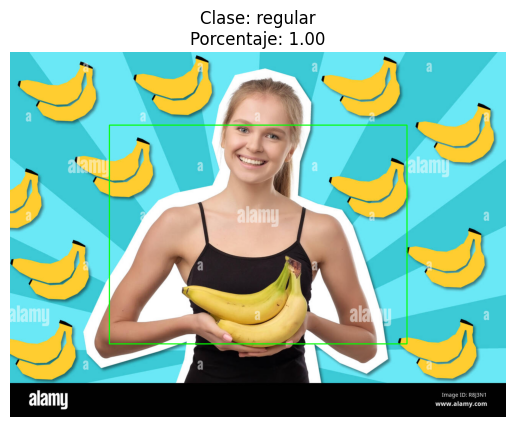

In [39]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Preprocesamiento de imágenes
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Cargar el modelo previamente guardado
model = CNN()  # Asegúrate de tener la definición de la clase CNN correspondiente a tu modelo
model.load_state_dict(torch.load('calidadplatano.pth'))
model.eval()

# Función para clasificar la imagen de entrada y mostrar el rectángulo
def classify_and_visualize(input_image):
    input_image_copy = input_image.copy()
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    input_image = Image.fromarray(input_image)
    input_image = transform(input_image).unsqueeze(0)
    output = model(input_image)
    probabilities = torch.softmax(output, dim=1).squeeze().detach().cpu().numpy()
    class_labels = ['baja', 'regular', 'excelente', 'mala']
    predicted_class = class_labels[np.argmax(probabilities)]
    confidence = probabilities[np.argmax(probabilities)]

    # Obtener las dimensiones del rectángulo
    height, width, _ = input_image_copy.shape
    start_x = int(width * 0.2)
    start_y = int(height * 0.2)
    end_x = int(width * 0.8)
    end_y = int(height * 0.8)

    # Dibujar el rectángulo en la imagen original
    cv2.rectangle(input_image_copy, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)

    # Mostrar los resultados
    plt.imshow(cv2.cvtColor(input_image_copy, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Clase: {predicted_class}\nPorcentaje: {confidence:.2f}")
    plt.show()

# Cargar una imagen de prueba
image_path = '/content/arte.jpg'  # Ruta de la imagen de prueba
input_image = cv2.imread(image_path)

# Clasificar y visualizar la imagen
classify_and_visualize(input_image)


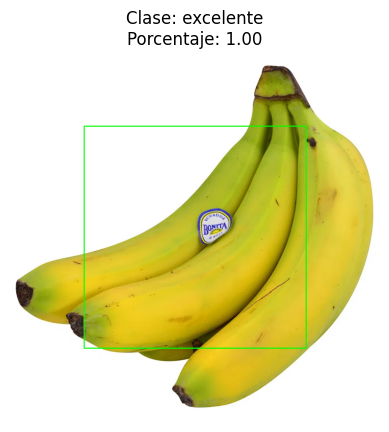

In [40]:
# Cargar una imagen de prueba
image_path = '/content/bonito.webp'  # Ruta de la imagen de prueba
input_image = cv2.imread(image_path)

# Clasificar y visualizar la imagen
classify_and_visualize(input_image)

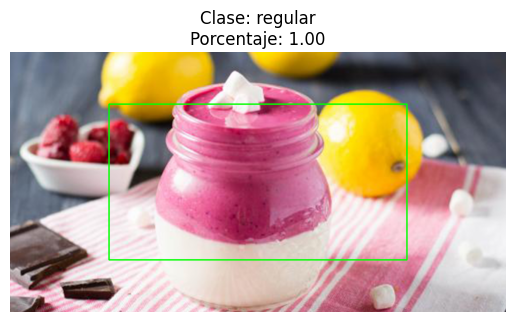

In [41]:
# Cargar una imagen de prueba
image_path = '/content/noplatano.png'  # Ruta de la imagen de prueba
input_image = cv2.imread(image_path)

# Clasificar y visualizar la imagen
classify_and_visualize(input_image)

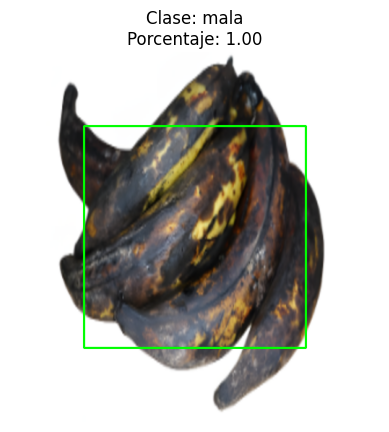

In [42]:
# Cargar una imagen de prueba
image_path = '/content/mala.png'  # Ruta de la imagen de prueba
input_image = cv2.imread(image_path)

# Clasificar y visualizar la imagen
classify_and_visualize(input_image)

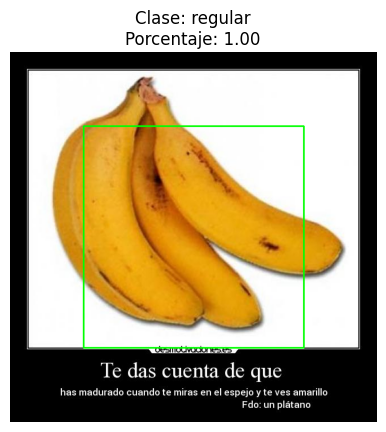

In [44]:
# Cargar una imagen de prueba
image_path = '/content/platano_6.jpg'  # Ruta de la imagen de prueba
input_image = cv2.imread(image_path)

# Clasificar y visualizar la imagen
classify_and_visualize(input_image)

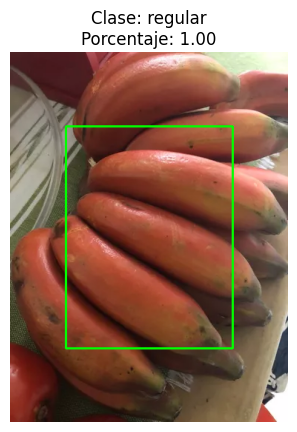

In [45]:
# Cargar una imagen de prueba
image_path = '/content/rojo.webp'  # Ruta de la imagen de prueba
input_image = cv2.imread(image_path)

# Clasificar y visualizar la imagen
classify_and_visualize(input_image)

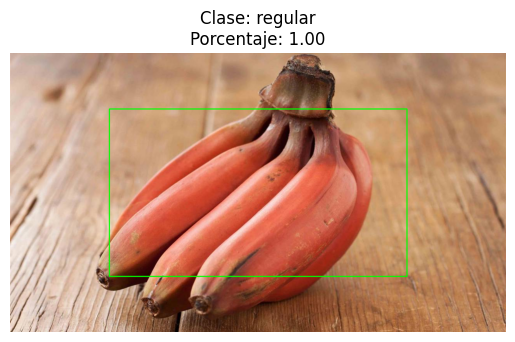

In [46]:
# Cargar una imagen de prueba
image_path = '/content/rojov2.jpg'  # Ruta de la imagen de prueba
input_image = cv2.imread(image_path)

# Clasificar y visualizar la imagen
classify_and_visualize(input_image)

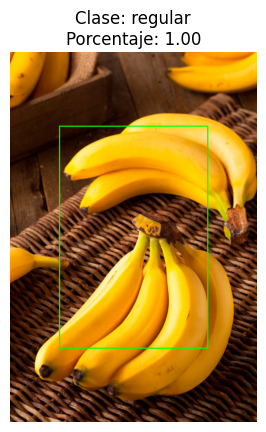

In [47]:
# Cargar una imagen de prueba
image_path = '/content/cesta.jpg'  # Ruta de la imagen de prueba
input_image = cv2.imread(image_path)

# Clasificar y visualizar la imagen
classify_and_visualize(input_image)

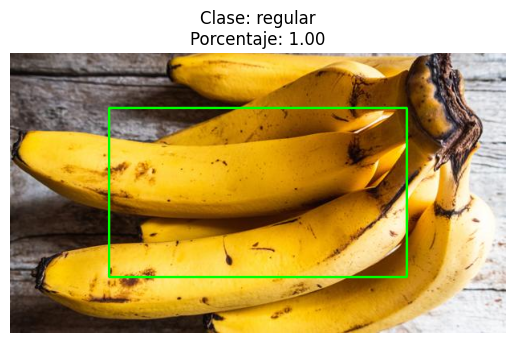

In [48]:
# Cargar una imagen de prueba
image_path = '/content/platano-beneficios-1-kVAG--620x349@abc.jpg'  # Ruta de la imagen de prueba
input_image = cv2.imread(image_path)

# Clasificar y visualizar la imagen
classify_and_visualize(input_image)

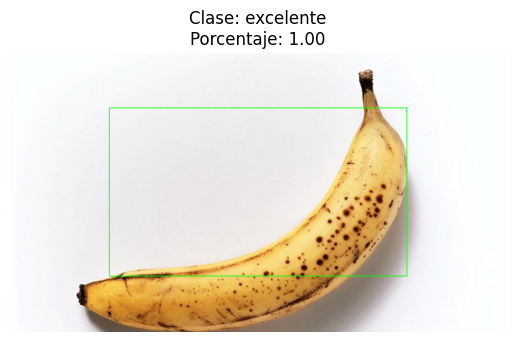

In [49]:
# Cargar una imagen de prueba
image_path = '/content/imagen-de-un-platano-maduro.jpeg'  # Ruta de la imagen de prueba
input_image = cv2.imread(image_path)

# Clasificar y visualizar la imagen
classify_and_visualize(input_image)

In [ ]:

# Función para clasificar la imagen de entrada
def classify_image(input_image):
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    input_image = transform(input_image).unsqueeze(0)
    input_image = input_image.to(device)

    output = model(input_image)
    probabilities = torch.softmax(output, dim=1).squeeze().cpu().numpy()

    class_labels = ['excelente', 'regular', 'baja', 'mala']
    table_data = {'Clase': class_labels, 'Porcentaje': probabilities}
    return table_data

# Interfaz de usuario web con Gradio
inputs = gr.Image()
outputs = gr.Textbox(headers=['Clase', 'Porcentaje'])
title = "Clasificación de calidad de plátanos"
description = "Carga una imagen de plátano y obtén la clasificación de calidad."

gr.Interface(fn=classify_image, inputs=inputs, outputs=outputs, title=title, description=description).launch()

In [51]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import cv2
import numpy as np
from PIL import Image
import gradio as gr

# Preprocesamiento de imágenes
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Cargar el modelo previamente guardado
model = CNN()  # Asegúrate de tener la definición de la clase CNN correspondiente a tu modelo
model.load_state_dict(torch.load('calidadplatano.pth'))
model.eval()

# Función para clasificar la imagen de entrada
def classify_image(input_image):
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    input_image = Image.fromarray(input_image)
    input_image = transform(input_image).unsqueeze(0)
    output = model(input_image)
    probabilities = torch.softmax(output, dim=1).squeeze().detach().cpu().numpy()
    class_labels = ['baja', 'regular', 'excelente', 'mala']
    predicted_class = class_labels[np.argmax(probabilities)]
    confidence = probabilities[np.argmax(probabilities)]
    return predicted_class, confidence

# Definir la interfaz gráfica de usuario
inputs = gr.inputs.Image()
outputs = gr.outputs.Label(num_top_classes=1)

def process_image(input_image):
    predicted_class, confidence = classify_image(input_image)
    return predicted_class

title = "Clasificación de calidad de plátanos"
description = "Carga una imagen de plátano y obtén la clasificación de calidad."
gr.Interface(fn=process_image, inputs=inputs, outputs=outputs, title=title, description=description).launch(share=True)



<ipython-input-51-d678200dc081>:34: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  inputs = gr.inputs.Image()
<ipython-input-51-d678200dc081>:34: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  inputs = gr.inputs.Image()
<ipython-input-51-d678200dc081>:35: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  outputs = gr.outputs.Label(num_top_classes=1)
<ipython-input-51-d678200dc081>:35: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remove them: {'type': 'auto'}
  outputs = gr.outputs.Label(num_top_classes=1)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://2655384537b9d38af3.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [53]:
from google.colab import drive
drive.mount('/content/drive')

import shutil

# Ruta del archivo calidadplatano.pth en tu entorno de Google Colab
source_path = '/content/calidadplatano.pth'

# Ruta de destino en tu Google Drive
destination_path = '/content/drive/MyDrive/calidadplatano.pth'

# Copiar el archivo a tu Google Drive
shutil.copyfile(source_path, destination_path)


Mounted at /content/drive


'/content/drive/MyDrive/calidadplatano.pth'

In [ ]:
!pip install gradio
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import cv2
import numpy as np
from PIL import Image
import gradio as gr
from google.colab import drive
drive.mount('/content/drive')

# Preprocesamiento de imágenes
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 256 * 256, 128)
        self.fc2 = nn.Linear(128, 4)  # 4 clases: excelente, regular, baja, mala

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Cargar el modelo previamente guardado
model = CNN()  # Asegúrate de tener la definición de la clase CNN correspondiente a tu modelo
model.load_state_dict(torch.load('/content/drive/MyDrive/calidadplatano.pth'))
model.eval()

# Función para clasificar la imagen de entrada
def classify_image(input_image):
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    input_image = Image.fromarray(input_image)
    input_image = transform(input_image).unsqueeze(0)
    output = model(input_image)
    probabilities = torch.softmax(output, dim=1).squeeze().detach().cpu().numpy()
    class_labels = ['baja', 'regular', 'excelente', 'mala']
    predicted_class = class_labels[np.argmax(probabilities)]
    confidence = probabilities[np.argmax(probabilities)]
    return predicted_class, confidence

# Definir la interfaz gráfica de usuario
inputs = gr.inputs.Image()
outputs = gr.outputs.Label(num_top_classes=1)

def process_image(input_image):
    predicted_class, confidence = classify_image(input_image)
    return predicted_class

title = "Clasificación de calidad de plátanos"
description = "Carga una imagen de plátano y obtén la clasificación de calidad."
gr.Interface(fn=process_image, inputs=inputs, outputs=outputs, title=title, description=description).launch(share=True)
